In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [2]:
## Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [3]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [4]:

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_cont2"] = estreams_attributes["perm_high_cont"]
estreams_attributes["perm_medium_cont2"] = estreams_attributes["perm_medium_cont"] + estreams_attributes["perm_low_cont"]
estreams_attributes["perm_low_cont2"] = estreams_attributes["perm_verylow_cont"]


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [ ]:
FR003922, FR002029, BEVL0155, ES001243

In [49]:
BASIN_ID = "ES001243"

In [51]:
# First we define the outlet of the Moselle to be used
outlets = [BASIN_ID]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs[BASIN_ID]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]
estreams_attributes_clipped_filters

100%|██████████| 1/1 [00:00<00:00, 1463.98it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
ES001231,3001,PERALEJOS DE LAS TRUCHAS,ES,ES_CEDEX,NaN,-1.931964,40.594145,-1.931964,40.594145,1143,...,3.295,0.670,3.408,0.0,16.0,84.0,0.0,8.273,90.113,1.614
ES001233,3003,LORANCA DE TAJUÑA,ES,ES_CEDEX,NaN,-3.095625,40.455656,-3.095625,40.455656,666,...,0.649,8.423,30.527,1.0,8.0,92.0,0.0,41.822,58.145,0.032
ES001235,3005,TRILLO,ES,ES_CEDEX,NaN,-2.585875,40.696157,-2.585875,40.696157,720,...,1.348,4.494,26.287,1.0,9.0,91.0,0.0,34.175,62.006,3.819
ES001241,3012,"PORTUSA, LA",ES,ES_CEDEX,NaN,-4.182675,39.885137,-4.182675,39.885137,430,...,0.798,640.246,1163.774,11.0,17.0,75.0,8.0,49.515,38.991,11.491
ES001257,3030,VENTOSA,ES,ES_CEDEX,NaN,-1.965226,40.829235,-1.965226,40.829235,1016,...,1.266,1.553,9.054,1.0,2.0,98.0,0.0,33.967,59.104,6.930
ES001262,3041,ALCANTUD,ES,ES_CEDEX,NaN,-2.325721,40.507594,-2.325721,40.507594,754,...,1.514,2.171,26.816,0.0,13.0,87.0,0.0,15.540,82.949,1.512
ES001264,3045,PRIEGO (ESCABAS),ES,ES_CEDEX,NaN,-2.311326,40.443671,-2.311326,40.443671,818,...,1.265,0.563,10.798,0.0,20.0,80.0,0.0,29.654,70.346,0.000
ES001270,3051,ALGETE,ES,ES_CEDEX,NaN,-3.566491,40.587009,-3.566491,40.587009,585,...,2.053,26.301,31.920,2.0,15.0,47.0,38.0,32.495,38.968,28.538
ES001271,3052,MEJORADA DEL CAMPO,ES,ES_CEDEX,NaN,-3.509440,40.395212,-3.509440,40.395212,550,...,1.252,133.840,191.085,6.0,22.0,64.0,14.0,48.569,33.298,18.133


In [52]:
estreams_attributes_clipped_filters.corr(method="spearman")["baseflow_index"][-10:]

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_63734/3158332290.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped_filters.corr(method="spearman")["baseflow_index"][-10:]


sno_cov_mean          -0.043605
irri_1990              0.210697
irri_2005              0.343005
stations_num_p_mean    0.264068
perm_high_glob2       -0.177713
perm_medium_glob2      0.664336
perm_low_glob2        -0.506110
perm_high_cont2        0.208156
perm_medium_cont2      0.408049
perm_low_cont2        -0.553160
Name: baseflow_index, dtype: float64

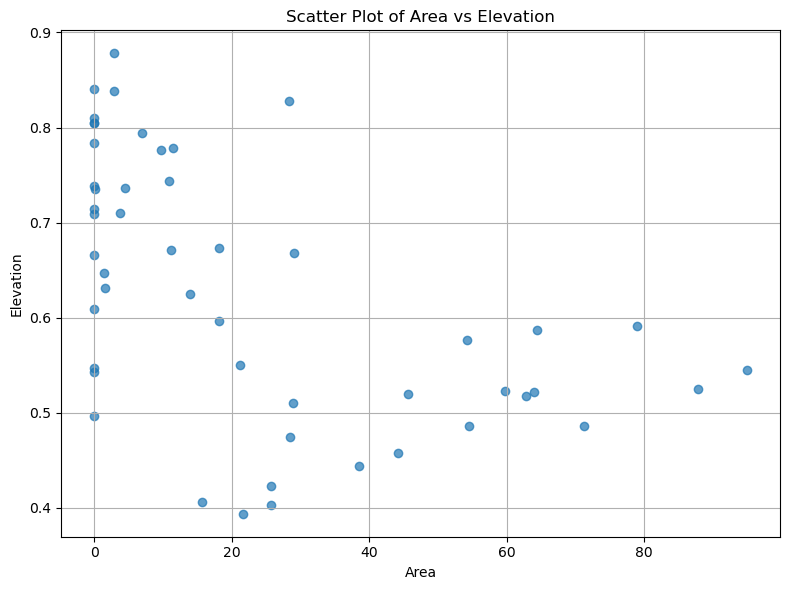

In [53]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_cont2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


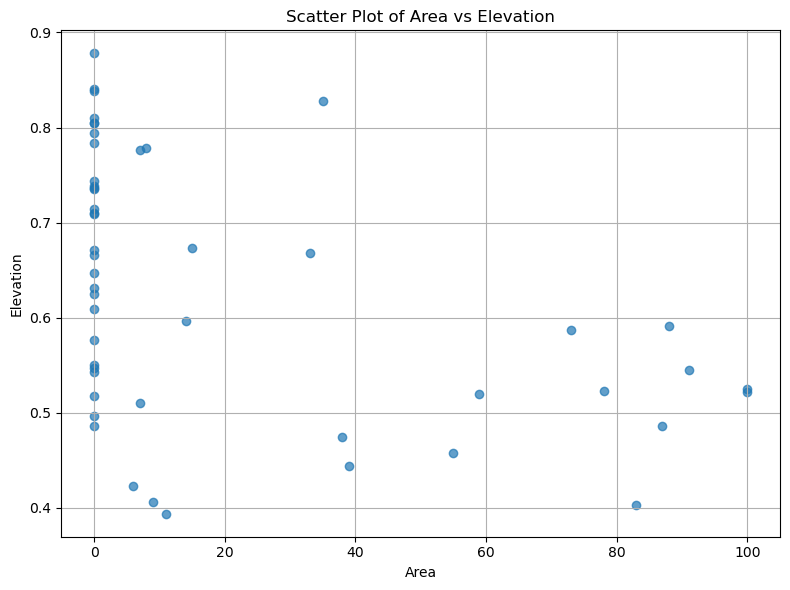

In [54]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_glob2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
len(estreams_attributes_clipped_filters)

52

In [56]:
estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
ES001231,3001,PERALEJOS DE LAS TRUCHAS,ES,ES_CEDEX,NaN,-1.931964,40.594145,-1.931964,40.594145,1143,...,3.295,0.670,3.408,0.0,16.0,84.0,0.0,8.273,90.113,1.614
ES001233,3003,LORANCA DE TAJUÑA,ES,ES_CEDEX,NaN,-3.095625,40.455656,-3.095625,40.455656,666,...,0.649,8.423,30.527,1.0,8.0,92.0,0.0,41.822,58.145,0.032
ES001235,3005,TRILLO,ES,ES_CEDEX,NaN,-2.585875,40.696157,-2.585875,40.696157,720,...,1.348,4.494,26.287,1.0,9.0,91.0,0.0,34.175,62.006,3.819
ES001241,3012,"PORTUSA, LA",ES,ES_CEDEX,NaN,-4.182675,39.885137,-4.182675,39.885137,430,...,0.798,640.246,1163.774,11.0,17.0,75.0,8.0,49.515,38.991,11.491
ES001257,3030,VENTOSA,ES,ES_CEDEX,NaN,-1.965226,40.829235,-1.965226,40.829235,1016,...,1.266,1.553,9.054,1.0,2.0,98.0,0.0,33.967,59.104,6.930
ES001262,3041,ALCANTUD,ES,ES_CEDEX,NaN,-2.325721,40.507594,-2.325721,40.507594,754,...,1.514,2.171,26.816,0.0,13.0,87.0,0.0,15.540,82.949,1.512
ES001264,3045,PRIEGO (ESCABAS),ES,ES_CEDEX,NaN,-2.311326,40.443671,-2.311326,40.443671,818,...,1.265,0.563,10.798,0.0,20.0,80.0,0.0,29.654,70.346,0.000
ES001270,3051,ALGETE,ES,ES_CEDEX,NaN,-3.566491,40.587009,-3.566491,40.587009,585,...,2.053,26.301,31.920,2.0,15.0,47.0,38.0,32.495,38.968,28.538
ES001271,3052,MEJORADA DEL CAMPO,ES,ES_CEDEX,NaN,-3.509440,40.395212,-3.509440,40.395212,550,...,1.252,133.840,191.085,6.0,22.0,64.0,14.0,48.569,33.298,18.133


In [57]:
basins_problems2 = pd.read_csv(r"../data/basins_problems_filter_2.csv")
basins_problems2

,basin
0,AT000080
1,AT000120
2,AT000159
3,AT000372
4,AT000373
...,...
369,SE000083
370,SE000103
371,SE000118
372,SI000029


In [58]:
Outliers = ["DEBB0050", 
"DK000087",
"ES000172",
"ES000478",
"ES001114",
"FI000202",
"FI000506",
"FR001271",
"FR001475",
"ITIS0107",
"NL000012",
"PT000211",
"PT000218",
"PT000263",
"DEHE0953",
"DEHE0970",
"DEHE0989",
"DEHE1008",
"DEHE1013",
"DEHE1014",
"DK000094"]

In [59]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[~estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]
#estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters2.drop(["FR001217", "FR001219", "FR003943", "FR001180"])

len(estreams_attributes_clipped_filters2)

50

In [36]:
# Create a folder to save the plots
output_dir = r"../results/plots/talavera"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    #csv_file = fr"C:/Users/nascimth/Documents/data/EStreams/data/estreams_timeseries_{basin_id}.csv"
    csv_file = fr'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Data/data/estreams_timeseries_{basin_id}.csv'
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.xlim("1988","2015")

    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 26/26 [00:02<00:00, 12.14it/s]


In [61]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters2.drop(["ES001243", 
"ES001287", 
"ES001288", 
"ES001292",
#"FR000457",
"ES001339",
"ES001352",
"ES001384",
"ES001395",
#"ES001403",
])


<Axes: >

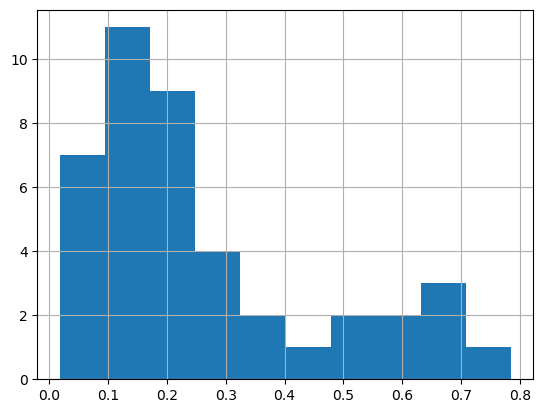

In [62]:
estreams_attributes_clipped_filters2.q_runoff_ratio.hist()

In [63]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
ES001233    0.115
ES001241    0.158
ES001257    0.121
ES001270    0.159
ES001271    0.213
ES001273    0.178
ES001275    0.186
ES001276    0.203
ES001277    0.178
ES001283    0.238
ES001287    0.186
ES001288    0.146
ES001292    0.263
ES001315    0.151
ES001320    0.103
ES001331    0.111
ES001332    0.066
ES001345    0.103
ES001351    0.115
ES001352    0.271
ES001356    0.173
ES001363    0.235
ES001377    0.032
ES001379    0.133
ES001380    0.018
ES001384    0.105
ES001390    0.211
ES001395    0.063
ES001397    0.088
ES001400    0.289
ES001401    0.051
ES001403    0.080
ES001404    0.094
ES001411    0.056
ES001416    0.033
ES001432    0.134
ES001243    0.207
Name: q_runoff_ratio, dtype: float64

In [64]:
estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
ES001231,3001,PERALEJOS DE LAS TRUCHAS,ES,ES_CEDEX,NaN,-1.931964,40.594145,-1.931964,40.594145,1143,...,3.295,0.670,3.408,0.0,16.0,84.0,0.0,8.273,90.113,1.614
ES001233,3003,LORANCA DE TAJUÑA,ES,ES_CEDEX,NaN,-3.095625,40.455656,-3.095625,40.455656,666,...,0.649,8.423,30.527,1.0,8.0,92.0,0.0,41.822,58.145,0.032
ES001235,3005,TRILLO,ES,ES_CEDEX,NaN,-2.585875,40.696157,-2.585875,40.696157,720,...,1.348,4.494,26.287,1.0,9.0,91.0,0.0,34.175,62.006,3.819
ES001241,3012,"PORTUSA, LA",ES,ES_CEDEX,NaN,-4.182675,39.885137,-4.182675,39.885137,430,...,0.798,640.246,1163.774,11.0,17.0,75.0,8.0,49.515,38.991,11.491
ES001257,3030,VENTOSA,ES,ES_CEDEX,NaN,-1.965226,40.829235,-1.965226,40.829235,1016,...,1.266,1.553,9.054,1.0,2.0,98.0,0.0,33.967,59.104,6.930
ES001262,3041,ALCANTUD,ES,ES_CEDEX,NaN,-2.325721,40.507594,-2.325721,40.507594,754,...,1.514,2.171,26.816,0.0,13.0,87.0,0.0,15.540,82.949,1.512
ES001264,3045,PRIEGO (ESCABAS),ES,ES_CEDEX,NaN,-2.311326,40.443671,-2.311326,40.443671,818,...,1.265,0.563,10.798,0.0,20.0,80.0,0.0,29.654,70.346,0.000
ES001270,3051,ALGETE,ES,ES_CEDEX,NaN,-3.566491,40.587009,-3.566491,40.587009,585,...,2.053,26.301,31.920,2.0,15.0,47.0,38.0,32.495,38.968,28.538
ES001271,3052,MEJORADA DEL CAMPO,ES,ES_CEDEX,NaN,-3.509440,40.395212,-3.509440,40.395212,550,...,1.252,133.840,191.085,6.0,22.0,64.0,14.0,48.569,33.298,18.133


In [65]:
import pandas as pd
import os
import tqdm

data_folder = r"C:/Users/nascimth/Documents/data/EStreams/data"
data_folder = fr'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Data/data/'

gantt_segments = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters2.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")

    # Load CSV with datetime index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data.loc["1988-10-01":"2015-09-30"]

    # Get availability mask
    valid = data["q_mean"].notna()

    # Identify change points in availability (True to False or vice-versa)
    change_points = valid.ne(valid.shift()).cumsum()

    # Group by continuous segments
    for grp, seg in data[valid].groupby(change_points):
        start = seg.index.min()
        end = seg.index.max()
        gantt_segments.append((basin_id, start, end))


100%|██████████| 42/42 [00:00<00:00, 42.96it/s]


In [66]:
gantt_df = pd.DataFrame(gantt_segments, columns=["basin", "start", "end"])
gantt_df = gantt_df.sort_values(["basin", "start"]).reset_index(drop=True)

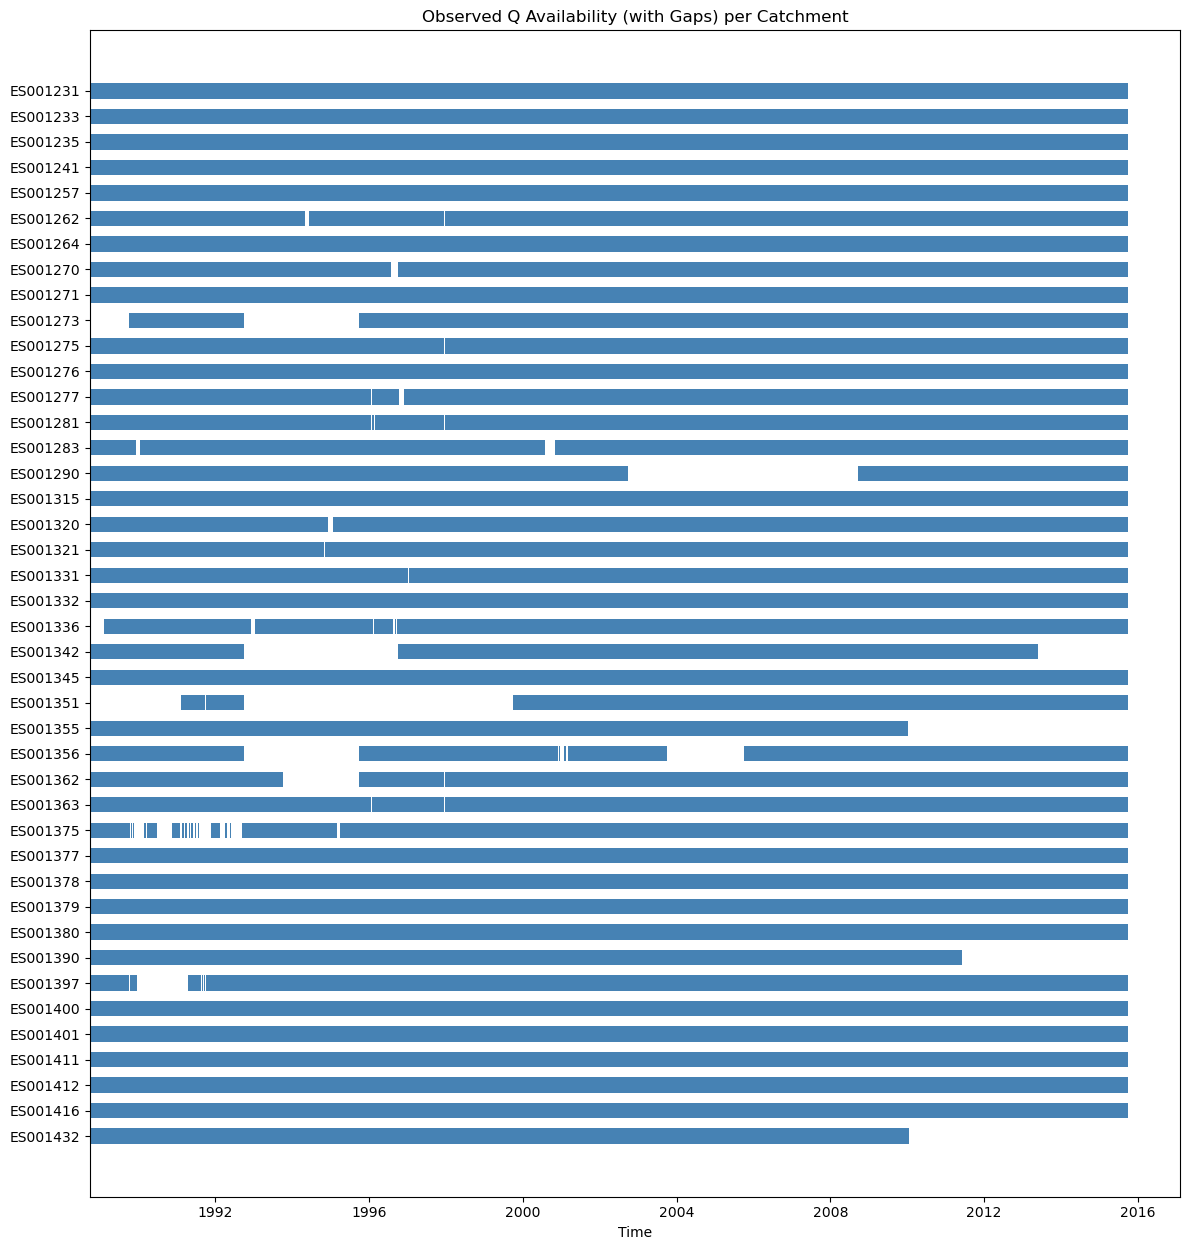

In [67]:
import matplotlib.pyplot as plt

# Assign a numeric index for plotting on y-axis
basin_to_y = {basin: i for i, basin in enumerate(gantt_df["basin"].unique())}
gantt_df["y"] = gantt_df["basin"].map(basin_to_y)

fig, ax = plt.subplots(figsize=(12, len(basin_to_y) * 0.3))

for _, row in gantt_df.iterrows():
    width = (row["end"] - row["start"]).days
    ax.barh(y=row["y"], left=row["start"], width=width, height=0.6, color="steelblue")

ax.set_yticks(list(basin_to_y.values()))
ax.set_yticklabels(list(basin_to_y.keys()))
ax.invert_yaxis()
ax.set_xlabel("Time")
ax.set_title("Observed Q Availability (with Gaps) per Catchment")
plt.tight_layout()
plt.show()


In [69]:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes_clipped_filters2.copy()

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

estreams_attributes_clipped_sorted.loc[:, ["area_estreams"]]

,area_estreams
basin_id,
ES001375,54.635
ES001355,60.875
ES001411,86.277
ES001362,136.642
ES001412,185.152
ES001400,207.440
ES001397,221.491
ES001290,235.745
ES001273,238.601


In [30]:
import geopandas as gpd
moselle=gpd.read_file(r"../data/shps\moselle_delienation.shp")
garonne=gpd.read_file(r"..\data\shps\garonne.shp")
five_cats=gpd.read_file(r"..\data\shps\five_cats.shp")

rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

### Current approach

In [70]:
import numpy as np
import pandas as pd

# Parameters
n_groups = 3

# Base dataframe
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

total_gauges = len(df_sorted)

# Step 1: Sort by area for stratification
df_sorted = df_sorted.sort_values(by="area_estreams").reset_index(drop=True)

# Step 2: Determine gauges per group
gauges_per_group = total_gauges // n_groups
extra_gauges = total_gauges % n_groups  # Remainder

# Step 3: Create strata for balanced sampling
strata = np.array_split(df_sorted, total_gauges)

# Step 4: Round-robin assignment with randomness
np.random.seed(42)
grouped_gauges = {f'Group_{i+1}': [] for i in range(n_groups)}
group_cycle = list(grouped_gauges.keys()) * ((len(strata) // n_groups) + 2)
group_idx = 0

for stratum in strata:
    selected = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    group = group_cycle[group_idx]
    grouped_gauges[group].append(selected)
    group_idx += 1

# Step 5: Convert to DataFrames
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}
all_combined = pd.concat(groups_df.values())

# Final checks
print(f"\n✅ Total gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# Summary per group
for k, g in groups_df.items():
    print(f"{k}: {len(g)} gauges | Mean area: {g['area_estreams'].mean():.1f}")



✅ Total gauges assigned: 42 (should be 42)
✅ Unique basin_ids: 42 (should be 42)
✅ Any duplicates? False
Group_1: 14 gauges | Mean area: 1155.9
Group_2: 14 gauges | Mean area: 2512.7
Group_3: 14 gauges | Mean area: 2794.7


In [71]:
groups_df["Group_1"]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id
0,3228,PEGUERINOS,ES,ES_CEDEX,NaN,-4.218309,40.603738,-4.218309,40.603738,1210,...,0.000,0.153,0.0,0.0,0.0,100.0,0.000,36.030,63.970,ES001375
1,3211,VILLAREJO DE MONTALBAN,ES,ES_CEDEX,NaN,-4.567029,39.770989,-4.567029,39.770989,509,...,0.000,2.139,0.0,43.0,51.0,6.0,53.936,20.310,25.754,ES001362
2,3251,"PUEBLANUEVA, LA",ES,ES_CEDEX,NaN,-4.705105,39.918498,-4.705105,39.918498,404,...,0.362,6.541,0.0,36.0,55.0,9.0,40.349,43.890,15.761,ES001397
3,3273,VELILLA DE SAN ANTONIO,ES,ES_CEDEX,NaN,-3.482763,40.363957,-3.482763,40.363957,545,...,8.990,9.077,1.0,19.0,81.0,0.0,58.518,41.482,0.000,ES001416
4,3198,VILLAMANTILLA,ES,ES_CEDEX,NaN,-4.136642,40.369820,-4.136642,40.369820,497,...,1.700,2.097,0.0,11.0,34.0,55.0,46.599,9.229,44.173,ES001356
5,3045,PRIEGO (ESCABAS),ES,ES_CEDEX,NaN,-2.311326,40.443671,-2.311326,40.443671,818,...,0.563,10.798,0.0,20.0,80.0,0.0,29.654,70.346,0.000,ES001264
6,3212,MALPICA,ES,ES_CEDEX,NaN,-4.581911,39.918443,-4.581911,39.918443,388,...,3.405,18.699,0.0,22.0,67.0,11.0,36.633,41.685,21.683,ES001363
7,3232,VILLASECA,ES,ES_CEDEX,NaN,-3.830644,39.955469,-3.830644,39.955469,474,...,4.082,11.140,1.0,15.0,85.0,0.0,82.373,17.627,0.000,ES001379
8,3243,MINGORRUBIO,ES,ES_CEDEX,NaN,-3.791084,40.531060,-3.791084,40.531060,605,...,1.035,1.059,2.0,4.0,18.0,78.0,31.697,8.548,59.756,ES001390
9,3070,MADRID (P.SINDICAL),ES,ES_CEDEX,NaN,-3.747702,40.459548,-3.747702,40.459548,588,...,1.035,1.059,4.0,8.0,33.0,59.0,48.230,6.159,45.611,ES001283


In [72]:
groups_df["Group_3"][["basin_id", "area_estreams", 'perm_high_cont2',
       'perm_medium_cont2', 'perm_low_cont2']].sort_values("area_estreams")

,basin_id,area_estreams,perm_high_cont2,perm_medium_cont2,perm_low_cont2
0,ES001411,86.277,100.000,0.000,0.000
1,ES001400,207.440,17.062,82.940,0.000
2,ES001273,238.601,14.508,59.821,25.671
3,ES001332,260.501,92.351,7.649,0.000
4,ES001401,267.345,53.930,46.071,0.000
5,ES001345,388.799,61.126,38.874,0.000
6,ES001320,415.759,7.979,80.900,11.123
7,ES001281,521.085,20.067,25.460,54.473
8,ES001378,699.167,0.000,4.998,95.002
9,ES001275,1028.233,30.108,65.394,4.497


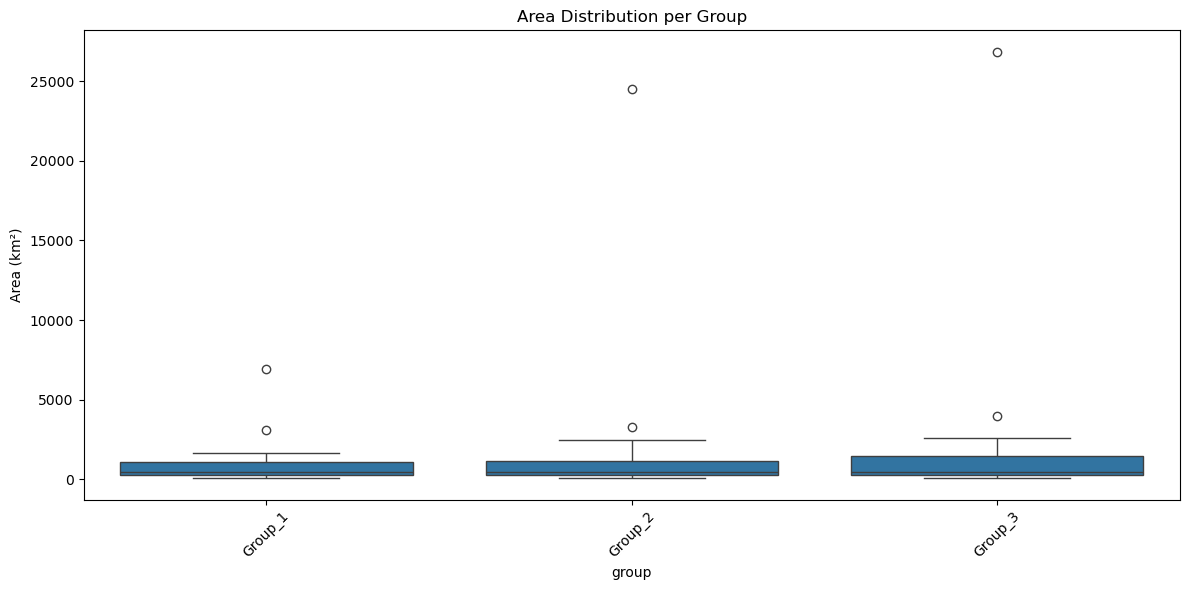

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: >

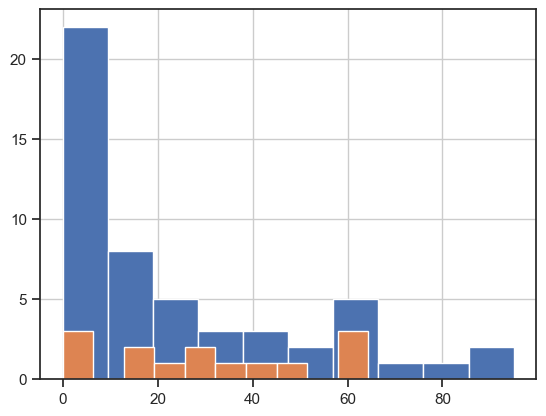

In [85]:
GROUP = "Group_1"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters.perm_low_cont2.hist()
estreams_attributes_clipped_filters.loc[list_cal].sort_values("area_estreams").perm_low_cont2.hist()

<Axes: >

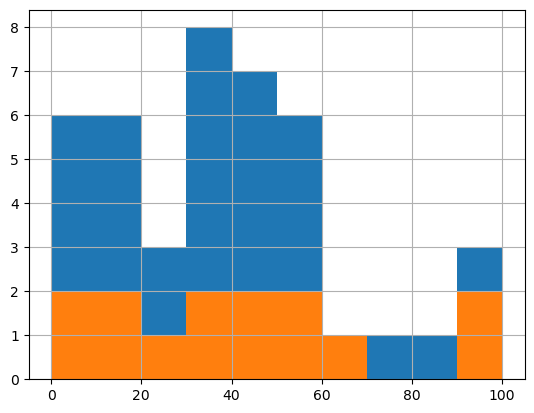

In [81]:
GROUP = "Group_3"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters2.perm_high_cont2.hist()
estreams_attributes_clipped_filters2.loc[list_cal].sort_values("area_estreams").perm_high_cont2.hist()

In [87]:
estreams_attributes_clipped_filters.perm_low_cont2.sort_values()

basin_id
ES001351     0.000
ES001379     0.000
ES001384     0.000
ES001332     0.000
ES001264     0.000
ES001416     0.000
ES001331     0.000
ES001395     0.000
ES001400     0.000
ES001411     0.000
ES001401     0.000
ES001345     0.000
ES001288     0.024
ES001233     0.032
ES001287     0.081
ES001262     1.512
ES001231     1.614
ES001403     2.833
ES001404     2.899
ES001235     3.819
ES001275     4.497
ES001257     6.930
ES001432     9.677
ES001412    10.962
ES001320    11.123
ES001241    11.491
ES001277    13.972
ES001397    15.761
ES001271    18.133
ES001243    18.164
ES001276    21.289
ES001363    21.683
ES001273    25.671
ES001362    25.754
ES001336    28.382
ES001270    28.538
ES001377    28.990
ES001292    29.089
ES001315    38.545
ES001356    44.173
ES001283    45.611
ES001355    54.199
ES001281    54.473
ES001390    59.756
ES001380    61.020
ES001321    62.865
ES001375    63.970
ES001342    64.367
ES001339    71.197
ES001352    78.976
ES001290    87.772
ES001378    95.002
Nam

In [88]:
import random

# Your required gauges
must_include = ['ES001290', 'ES001378']

# Make sure all must_include gauges exist in the full dataset
reference_df = pd.concat(groups_df.values()).drop_duplicates(subset="basin_id")

# Enforce presence in each group
for key, group_df in groups_df.items():
    # Check if group already has one of them
    if not any(basin in group_df["basin_id"].values for basin in must_include):
        # Pick a random gauge to inject
        chosen = random.choice(must_include)
        row = reference_df[reference_df["basin_id"] == chosen]
        if not row.empty:
            # Append the row to the group
            groups_df[key] = pd.concat([group_df, row], ignore_index=True)

In [90]:
# Final check
all_combined = pd.concat(groups_df.values())

print(f"\n✅ Total gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# LU per group
for k, g in groups_df.items():
    n_lu = g['basin_id'].str.contains("LU").sum()
    print(f"{k}: {len(g)} gauges | LU: {n_lu} | Mean area: {g['area_estreams'].mean():.1f}")



✅ Total gauges assigned: 43 (should be 42)
✅ Unique basin_ids: 42 (should be 42)
✅ Any duplicates? True
Group_1: 15 gauges | LU: 0 | Mean area: 1094.5
Group_2: 14 gauges | LU: 0 | Mean area: 2512.7
Group_3: 14 gauges | LU: 0 | Mean area: 2794.7


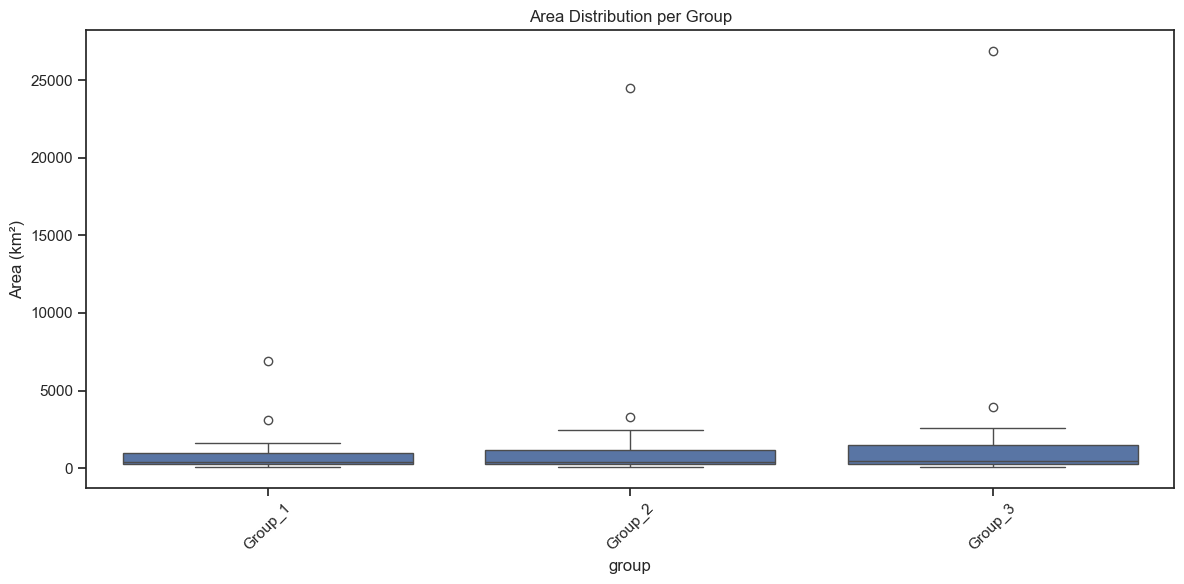

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


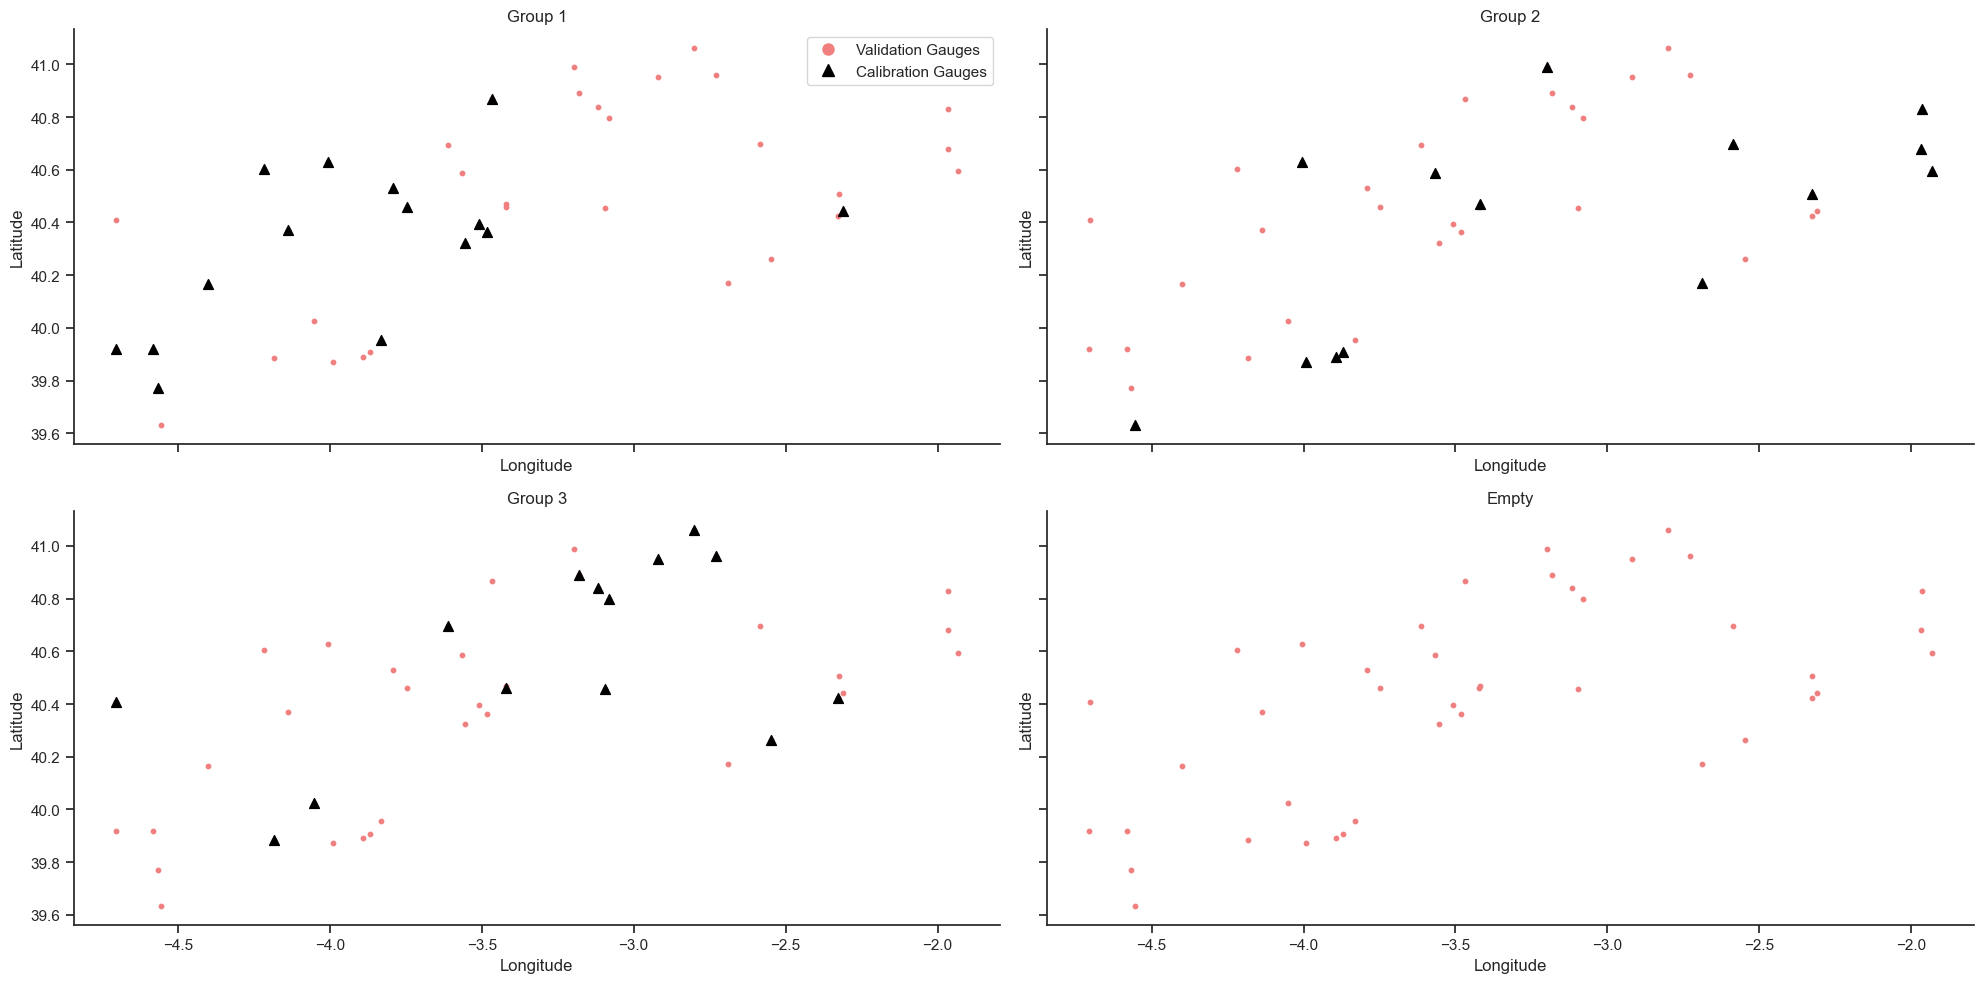

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

sns.set_theme(style="ticks")

# Prepare data
df = estreams_attributes_clipped_filters2.copy()
group_coords = [group[["basin_id"]] for group in groups_df.values()]
group_coords = [network_estreams.loc[g["basin_id"].tolist()] for g in group_coords]

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Base map
    #five_cats[five_cats.basin_id == "FR003986"].plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    #rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # All gauges in red (background)
    ax.scatter(
        df["lon"], df["lat"],
        color='lightcoral', s=10, label='Validation Gauges', zorder=2
    )

    if i < len(group_coords):
        # Plot group gauges (triangle)
        ax.scatter(
            group_coords[i]["lon"],
            group_coords[i]["lat"],
            marker='^',
            color='black',
            s=50,
            zorder=3,
            label=f'Group {i+1}'
        )
        ax.set_title(f"Group {i+1}")
    else:
        ax.set_title("Empty")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(False)
    sns.despine(ax=ax)

# Legend (shared handles)
validation_handle = mlines.Line2D([], [], color='lightcoral', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')
axes[0].legend(handles=[validation_handle, calibration_handle], loc='upper right')

plt.tight_layout()
plt.show()


In [95]:
combined_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,3228,PEGUERINOS,ES,ES_CEDEX,NaN,-4.218309,40.603738,-4.218309,40.603738,1210,...,0.153,0.0,0.0,0.0,100.0,0.000,36.030,63.970,ES001375,Group_1
1,3211,VILLAREJO DE MONTALBAN,ES,ES_CEDEX,NaN,-4.567029,39.770989,-4.567029,39.770989,509,...,2.139,0.0,43.0,51.0,6.0,53.936,20.310,25.754,ES001362,Group_1
2,3251,"PUEBLANUEVA, LA",ES,ES_CEDEX,NaN,-4.705105,39.918498,-4.705105,39.918498,404,...,6.541,0.0,36.0,55.0,9.0,40.349,43.890,15.761,ES001397,Group_1
3,3273,VELILLA DE SAN ANTONIO,ES,ES_CEDEX,NaN,-3.482763,40.363957,-3.482763,40.363957,545,...,9.077,1.0,19.0,81.0,0.0,58.518,41.482,0.000,ES001416,Group_1
4,3198,VILLAMANTILLA,ES,ES_CEDEX,NaN,-4.136642,40.369820,-4.136642,40.369820,497,...,2.097,0.0,11.0,34.0,55.0,46.599,9.229,44.173,ES001356,Group_1
5,3045,PRIEGO (ESCABAS),ES,ES_CEDEX,NaN,-2.311326,40.443671,-2.311326,40.443671,818,...,10.798,0.0,20.0,80.0,0.0,29.654,70.346,0.000,ES001264,Group_1
6,3212,MALPICA,ES,ES_CEDEX,NaN,-4.581911,39.918443,-4.581911,39.918443,388,...,18.699,0.0,22.0,67.0,11.0,36.633,41.685,21.683,ES001363,Group_1
7,3232,VILLASECA,ES,ES_CEDEX,NaN,-3.830644,39.955469,-3.830644,39.955469,474,...,11.140,1.0,15.0,85.0,0.0,82.373,17.627,0.000,ES001379,Group_1
8,3243,MINGORRUBIO,ES,ES_CEDEX,NaN,-3.791084,40.531060,-3.791084,40.531060,605,...,1.059,2.0,4.0,18.0,78.0,31.697,8.548,59.756,ES001390,Group_1
9,3070,MADRID (P.SINDICAL),ES,ES_CEDEX,NaN,-3.747702,40.459548,-3.747702,40.459548,588,...,1.059,4.0,8.0,33.0,59.0,48.230,6.159,45.611,ES001283,Group_1


In [96]:
combined_df.to_csv("../data/network_estreams_tavarela_42_gauges.csv")

# End